# 範例重點
了解如何在 Keras 中，加入 regularization  
熟悉建立、訓練模型  
熟悉將訓練結果視覺化並比較結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0915 19:52:42.269776  5672 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0915 19:52:42.270736  5672 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0915 19:52:42.316643  5672 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 19:52:42.317639  5672 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0915 19:52:42.528049  5672 deprecation.py:323] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 165us/step - loss: 15.0881 - acc: 0.2747 - val_loss: 13.9601 - val_acc: 0.3397
Epoch 2/50
50000/50000 [==============================] - 4s 82us/step - loss: 13.0245 - acc: 0.3578 - val_loss: 12.1439 - val_acc: 0.3711
Epoch 3/50
50000/50000 [==============================] - 4s 81us/step - loss: 11.3496 - acc: 0.3831 - val_loss: 10.5946 - val_acc: 0.3891
Epoch 4/50
50000/50000 [==============================] - 4s 84us/step - loss: 9.9363 - acc: 0.3956 - val_loss: 9.2952 - val_acc: 0.4062
Epoch 5/50
50000/50000 [==============================] - 4s 85us/step - loss: 8.7356 - acc: 0.4053 - val_loss: 8.1947 - val_acc: 0.4153
Epoch 6/50
50000/50000 [==============================] - 4s 85us/step - loss: 7.7140 - acc: 0.4128 - val_loss: 7.2524 - val_acc: 0.4209
Epoch 7/50
50000/50000 [==============================] - 4s 84us/step - loss: 6.8417 - acc: 0.4202 - val_loss: 6.4484 - 

50000/50000 [==============================] - 4s 83us/step - loss: 1.9384 - acc: 0.3683 - val_loss: 1.8857 - val_acc: 0.3855
Epoch 3/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.8543 - acc: 0.3972 - val_loss: 1.8329 - val_acc: 0.4057
Epoch 4/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.7957 - acc: 0.4176 - val_loss: 1.7715 - val_acc: 0.4310
Epoch 5/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.7491 - acc: 0.4350 - val_loss: 1.7394 - val_acc: 0.4342
Epoch 6/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.7107 - acc: 0.4476 - val_loss: 1.7068 - val_acc: 0.4462
Epoch 7/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.6776 - acc: 0.4590 - val_loss: 1.6824 - val_acc: 0.4575
Epoch 8/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.6468 - acc: 0.4711 - val_loss: 1.6549 - val_acc: 0.4602
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 4s 86us/step - loss: 1.7164 - acc: 0.3995 - val_loss: 1.6863 - val_acc: 0.4086
Epoch 4/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.6586 - acc: 0.4185 - val_loss: 1.6398 - val_acc: 0.4238
Epoch 5/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.6119 - acc: 0.4361 - val_loss: 1.5981 - val_acc: 0.4375
Epoch 6/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.5727 - acc: 0.4499 - val_loss: 1.5711 - val_acc: 0.4474
Epoch 7/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.5388 - acc: 0.4612 - val_loss: 1.5445 - val_acc: 0.4571
Epoch 8/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.5088 - acc: 0.4706 - val_loss: 1.5254 - val_acc: 0.4612
Epoch 9/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.4807 - acc: 0.4798 - val_loss: 1.5063 - val_acc: 0.4659
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 4s 84us/step - loss: 1.6584 - acc: 0.4181 - val_loss: 1.6325 - val_acc: 0.4318
Epoch 5/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.6122 - acc: 0.4381 - val_loss: 1.6007 - val_acc: 0.4377
Epoch 6/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.5740 - acc: 0.4499 - val_loss: 1.5624 - val_acc: 0.4545
Epoch 7/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.5408 - acc: 0.4603 - val_loss: 1.5381 - val_acc: 0.4610
Epoch 8/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.5104 - acc: 0.4705 - val_loss: 1.5193 - val_acc: 0.4622
Epoch 9/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.4833 - acc: 0.4803 - val_loss: 1.5108 - val_acc: 0.4653
Epoch 10/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.4581 - acc: 0.4898 - val_loss: 1.4820 - val_acc: 0.4755
Epoch 11/50
50000/50000 [==========================

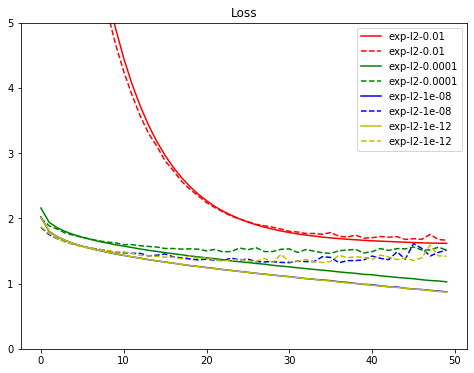

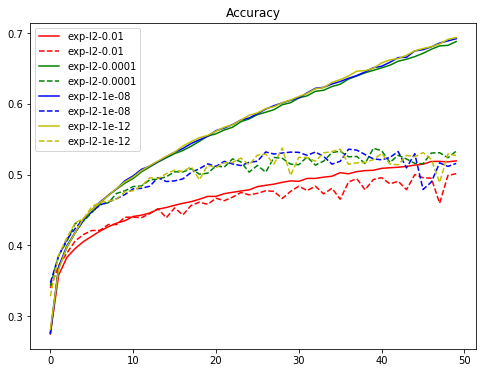

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()